In [1]:
import sys
sys.path.append('..')
from NCA.trainer.NCA_trainer import NCA_Trainer
from Common.utils import load_emoji_sequence
from Common.eddie_indexer import index_to_data_nca_type
from NCA.trainer.data_augmenter_nca import DataAugmenter
from NCA.model.NCA_model import NCA
from einops import rearrange
import time
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt

2024-07-23 14:08:21.598552: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 14:08:21.598613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 14:08:21.641515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 14:08:23.177292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## More customisation details
- This notebook follows on from `image_morph_demo.ipynb` but with more customisation options explored
- Included are:
    - creating custom subclasses of `DataAugmenter`
    - creating a `optax` optimiser to pass into `NCA_Trainer`
    - creating `BOUNDARY_MASK` to fix some spatial structure into some of the NCA channels
    - Setting optional parameters for the `train` method
    - Sparsity pruning during training

## Define stuff like before

In [2]:
CHANNELS = 16           # How many channels to use in the model
TRAINING_STEPS = 1000   # How many steps to train for
DOWNSAMPLE = 4          # How much to downsample the image by
NCA_STEPS = 32          # How many NCA steps between each image in the data sequence

In [3]:
model = NCA(N_CHANNELS=CHANNELS,
            KERNEL_STR=["ID","GRAD","LAP"],
            ACTIVATION=jax.nn.relu,
            PADDING="CIRCULAR",
            FIRE_RATE=0.5)

## Data Loading
- Here we load a sequence of 3 images, so that the NCA learns to take the 1st and morph it through the other two
- In `DataAugmenter` there are 2 important methods to overwrite: `data_init` and `data_callback`
  - `data_init` is called once at the start of training - this just sets things up 
  - `data_callback(x,y,i) -> x,y` takes as input the initial state and target state of each training iteration, modifies them and then returns them
    - This is useful for shifting images around, adding noise, removing segments of images to force regrowth, and to propagate intermediate states forwad throughout multi-step sequences

(Batch, Time, Channels, Width, Height): (1, 3, 4, 30, 30)


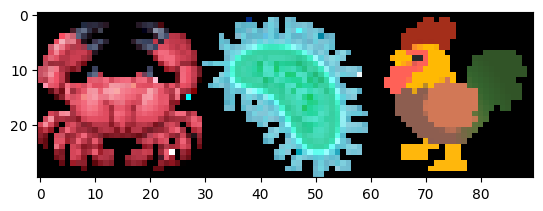

In [4]:
data = load_emoji_sequence(["crab.png","microbe.png","rooster.png"],impath_emojis="demo_data/",downsample=DOWNSAMPLE)

print("(Batch, Time, Channels, Width, Height): "+str(data.shape))
plt.imshow(rearrange(data,"() T C W H -> W (T H) C" )[...,:3])
plt.show()


class data_augmenter_subclass(DataAugmenter):
    #Redefine how data is pre-processed before training
    def data_init(self,SHARDING=None):
        data = self.return_saved_data()
        data = self.pad(data, 10) 		
        self.save_data(data)
        return None
    def data_callback(self,x,y,i):
        """
        Called after every training iteration to perform data augmentation and processing		

        Parameters
        ----------
        x : PyTree [BATCHES] f32[N-N_steps,CHANNELS,WIDTH,HEIGHT]
            Initial conditions
        y : PyTree [BATCHES] f32[N-N_steps,CHANNELS,WIDTH,HEIGHT]
            Final states
        i : int
            Current training iteration - useful for scheduling mid-training data augmentation

        Returns
        -------
        x : PyTree [BATCHES] f32[N-N_steps,CHANNELS,WIDTH,HEIGHT]
            Initial conditions
        y : PyTree [BATCHES] f32[N-N_steps,CHANNELS,WIDTH,HEIGHT]
            Final states

        """
        am=10
        
        if hasattr(self,"PREVIOUS_KEY"):
            x = self.unshift(x, am, self.PREVIOUS_KEY)
            y = self.unshift(y, am, self.PREVIOUS_KEY)

        x_true,_ =self.split_x_y(1)
                
        propagate_xn = lambda x:x.at[1:].set(x[:-1])
        reset_x0 = lambda x,x_true:x.at[0].set(x_true[0])
        
        x = jax.tree_util.tree_map(propagate_xn,x) # Set initial condition at each X[n] at next iteration to be final state from X[n-1] of this iteration
        x = jax.tree_util.tree_map(reset_x0,x,x_true) # Keep first initial x correct
        
                
        for b in range(len(x)//2):
            x[b*2] = x[b*2].at[:,:self.OBS_CHANNELS].set(x_true[b*2][:,:self.OBS_CHANNELS]) # Set every other batch of intermediate initial conditions to correct initial conditions
        
        if hasattr(self, "PREVIOUS_KEY"):
            key = jax.random.fold_in(self.PREVIOUS_KEY,i)
        else:
            key=jax.random.PRNGKey(int(time.time()))
        x = self.shift(x,am,key=key)
        y = self.shift(y,am,key=key)

        if i < 1000:
            x = self.zero_random_circle(x,key=key)
        x = self.noise(x,0.005,key=key)
        self.PREVIOUS_KEY = key
        return x,y
        


## Boundary mask
- Sometimes we want to encode something about spatial structure to the NCA
    - For example, we may be modelling complex boundary conditions that aren't a square, or we want learn two different behaviours that depend on some spatially varying parameter
- This is done via the `BOUNDARY_MASK` variable, an array of shape `[BoundaryChannels, Width, Height]` where
    - `BoundaryChannnels < HiddenChannels`
    - `Width` and `Height` match the data width and height
- During training, `BoundaryChannels` number of hidden channels will be forced to stay as the `BOUNDARY_MASK` variable
- The mask isn't saved with the model, so when running a trained NCA afterwards, do:
    - `nca(x,lambda x:x.at[-BoundaryChannels:].set(BOUNDARY_MASK))`
- In this example, we set 2 channels of the `BOUNDARY_MASK` to be horizontal and vertical stripes

(2, 50, 50)


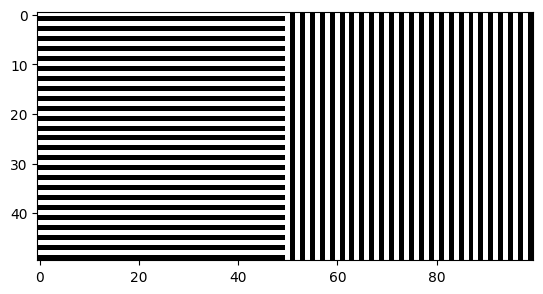

In [5]:
boundary_mask = np.zeros(data.shape[2:])[:2]
boundary_mask = np.pad(boundary_mask, ((0,0),(10,10),(10,10)))
print(boundary_mask.shape)
boundary_mask = boundary_mask.at[0,::2].set(1)
boundary_mask = boundary_mask.at[1,:,::2].set(1)

plt.imshow(rearrange(boundary_mask,"C W H -> W (C H)"),cmap="gray")

## Trainer initialisation
- Some customisation of the training process happens at initialisation time of the NCA_Trainer class
  - `DATA_AUGMENTER` can be given any subclass of `DataAugmenter`, which allows for defining custom behaviours for data augmentation during training
  - `BOUNDARY_MASK` defined above, needs to be passed in here
  - `GRAD_LOSS` flags whether to apply the loss function to just the cell states, or also to their spatial derivatives

In [6]:
trainer = NCA_Trainer(NCA_model=model,
                      data = data,
                      DATA_AUGMENTER=data_augmenter_subclass,
                      model_filename="test_morph_crab_microbe_rooster",
                      BOUNDARY_MASK=boundary_mask,
                      GRAD_LOSS=True,
                      )

Batches = 1
Logging training to: logs/test_morph_crab_microbe_rooster/train
Saving model to: models/test_morph_crab_microbe_rooster


## Training customisation
- There is plenty to customise here. Firstly, any optax gradient transformation works:
    - Here we have used a learn rate scheduler, with the NAdam optimiser with gradient block normalisation
- There are many optional parameters for `NCA_Trainer.train`:
    - `STATE_REGULARISER`: controls how strongly the NCA penalises any intermediate states going out of the range [0,1]
    - `WARMUP`: how many training steps to wait before saving models
    - `LOG_EVERY`: how frequently to log model behaviour during training. Making this too often can waste lots of storage
    - `WRITE_IMAGES`: whether to save intermediate image states or just losses
    - `LOSS_FUNC_STR`: string describing the loss function. Choose from: `"l2","l1","vgg","euclidean","spectral","spectral_full","rand_euclidean"`
    - `LOOP_AUTODIFF`: controls the internal `eqx.internal.scan` kind. Choose from `"checkpointed"` or `"lax"`. `"lax"` is generally faster, but uses much more RAM, especially for longer numbers of `NCA_STEPS`. `"checkpointed"` is a bit slower but uses less RAM
    - `SPARSITY_PRUNING`: whether to gradually prune the NCA parameters during training to a desired sparsity
    - `TARGET_SPARSITY`: Desired sparsity 

In [7]:
schedule = optax.exponential_decay(1e-3, transition_steps=TRAINING_STEPS, decay_rate=0.99)
optimiser = optax.chain(optax.scale_by_param_block_norm(),
                        optax.nadam(schedule))


trainer.train(t=NCA_STEPS,
              iters=TRAINING_STEPS,
              optimiser=optimiser,
              STATE_REGULARISER=1.0,
              WARMUP=100,
              LOG_EVERY=10,
              WRITE_IMAGES=True,
              LOSS_FUNC_STR="euclidean",
              LOOP_AUTODIFF="checkpointed",
              SPARSE_PRUNING=True,
              TARGET_SPARSITY=0.5)

  1%|          | 10/1000 [00:58<1:36:17,  5.84s/it]


KeyboardInterrupt: 

## Evaluating training:
- In the terminal, run the following command:

`tensorboard --samples_per_plugin images=200 --logdir logs/test_morph_crab_microbe_rooster/train/`

- Where `test_morph_crab_microbe_rooster` is the model filename we supplied when defining the `NCA_Trainer`

- Then, open your browser and go to: `http://localhost:6006/`